In [266]:
%pylab inline
import urllib, json
import pandas as pd
import re
from itertools import permutations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing


Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['grid', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [267]:
# concatenate the data from 2017, 2018 and 2019 into one Dataframe
files = ['NFL2017.csv', 'NFL2018.csv', 'NFL2019.csv']

f = []

for file in files:
    df = pd.read_csv(file).fillna(0)
    f.append(df)
    
data = pd.concat(f, axis=0, ignore_index=True)

In [268]:
# Drop the more advanced statistics/roles that we will not be using in this analysis.
# This reduces the number of features from 117 to 30 which will significantly improve the speed of the models.
data_2 = data.drop(['Date', 'Week', 'Year', 'Game ID', 'Opponent Score', 'OT', 'Spread', 'Over/Under', 'Implied Points', 
                    'Actual Margin', 'Rush Lng', 'Weather', 'Pass Lng', 
                    'Rec Lng', 'FL', 'Kick Ret', 'Kick Yds', 'Kick TD', 'Kick Lng', 'Kick YPR', 'Punt Ret', 'Punt Yds',
                    'Punt TD', 'Punt Lng', 'Punt YPR', 'Short L Tgt', 'Short L Ctch', 'Short L Yds', 'Short L TD', 
                    'Short M Tgt', 'Short M Ctch', 'Short M Yds', 'Short M TD', 'Short R Tgt', 'Short R Ctch', 
                    'Short R Yds', 'Short R TD', 'Deep L Tgt', 'Deep L Yds', 'Deep L TD', 'Deep L Ctch', 'Deep M Tgt', 'Deep M Ctch',
                    'Deep M Yds', 'Deep M TD', 'Deep R Tgt', 'Deep R Ctch', 'Deep R Yds', 'Deep R TD', 'No Dir Tgt', 
                    'No Dir Ctch', 'No Dir Yds', 'No Dir TD', 'Off Num', '2PT', 'Def Num', 'Def Pct', 'ST Num', 'ST Pct', 'Pnt', 'Yds',
                    'Y/P', 'Sk', 'Int', 'Int TD', 'FF', 'FR', 'Fum TD', 'QBHits', 'TFL', 'Oppt Int TD', 'Oppt Fum TD',
                    'Oppt Punt TD', 'Oppt Kick TD', 'FGM', 'FGA', 'FG 0-19', 'FG 20-29', 'FG 30-39', 'FG 40-49', 
                    'FG 50+', 'XPM', 'XPA', 'FDP', 'FDSalary', 'FD_Total_FP', 'YH_Total_FP'], axis=1)

In [269]:
# Also delete the Defensive, Fullback and Kicker player positions, as these are not chosen by the user in Draft Kings.
data_filtered = data_2[(data_2.Pos != 'K') & (data_2.Pos != 'DST') & (data_2.Pos != 'FB')] 

In [270]:
final_data = data_filtered

In [271]:
final_data

,Player,Pos,Team,Opponent Abbrev,H/A,Team Score,Indoor/Outdoor,Surface,Temperature,Wind,...,Rush TD,Rec Tgt,Rec Rec,Rec Yds,Rec TD,Fmb,Off Pct,DKP,DKSalary,DK_Total_FP
0,Alex Smith,QB,KAN,NWE,A,42.0,outdoors,fieldturf,63.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,100%,34.02,5400.0,34.02
1,Kareem Hunt,RB,KAN,NWE,A,42.0,outdoors,fieldturf,63.0,8.0,...,1.0,5.0,5.0,98.0,2.0,1.0,57%,49.60,5800.0,49.60
2,Charcandrick West,RB,KAN,NWE,A,42.0,outdoors,fieldturf,63.0,8.0,...,1.0,1.0,1.0,4.0,0.0,0.0,34%,9.50,4000.0,9.50
3,Tyreek Hill,WR,KAN,NWE,A,42.0,outdoors,fieldturf,63.0,8.0,...,0.0,8.0,7.0,133.0,1.0,1.0,74%,29.80,5700.0,29.80
4,Travis Kelce,TE,KAN,NWE,A,42.0,outdoors,fieldturf,63.0,8.0,...,0.0,7.0,5.0,40.0,0.0,0.0,99%,9.40,5600.0,9.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15508,Hunter Henry,TE,LAC,KAN,H,17.0,outdoors,grass,67.0,7.0,...,0.0,9.0,6.0,69.0,0.0,0.0,76%,14.90,5700.0,14.90
15509,Virgil Green,TE,LAC,KAN,H,17.0,outdoors,grass,67.0,7.0,...,0.0,1.0,1.0,8.0,0.0,0.0,30%,1.80,2500.0,1.80
15510,Troymaine Pope,RB,LAC,KAN,H,17.0,outdoors,grass,67.0,7.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1%,0.00,3000.0,0.00
15511,Andre Patton,WR,LAC,KAN,H,17.0,outdoors,grass,67.0,7.0,...,0.0,1.0,0.0,0.0,0.0,0.0,74%,0.00,3000.0,0.00


In [273]:
raw_data = final_data
raw_data

,Player,Pos,Team,Opponent Abbrev,H/A,Team Score,Indoor/Outdoor,Surface,Temperature,Wind,...,Rush TD,Rec Tgt,Rec Rec,Rec Yds,Rec TD,Fmb,Off Pct,DKP,DKSalary,DK_Total_FP
0,Alex Smith,QB,KAN,NWE,A,42.0,outdoors,fieldturf,63.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,100%,34.02,5400.0,34.02
1,Kareem Hunt,RB,KAN,NWE,A,42.0,outdoors,fieldturf,63.0,8.0,...,1.0,5.0,5.0,98.0,2.0,1.0,57%,49.60,5800.0,49.60
2,Charcandrick West,RB,KAN,NWE,A,42.0,outdoors,fieldturf,63.0,8.0,...,1.0,1.0,1.0,4.0,0.0,0.0,34%,9.50,4000.0,9.50
3,Tyreek Hill,WR,KAN,NWE,A,42.0,outdoors,fieldturf,63.0,8.0,...,0.0,8.0,7.0,133.0,1.0,1.0,74%,29.80,5700.0,29.80
4,Travis Kelce,TE,KAN,NWE,A,42.0,outdoors,fieldturf,63.0,8.0,...,0.0,7.0,5.0,40.0,0.0,0.0,99%,9.40,5600.0,9.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15508,Hunter Henry,TE,LAC,KAN,H,17.0,outdoors,grass,67.0,7.0,...,0.0,9.0,6.0,69.0,0.0,0.0,76%,14.90,5700.0,14.90
15509,Virgil Green,TE,LAC,KAN,H,17.0,outdoors,grass,67.0,7.0,...,0.0,1.0,1.0,8.0,0.0,0.0,30%,1.80,2500.0,1.80
15510,Troymaine Pope,RB,LAC,KAN,H,17.0,outdoors,grass,67.0,7.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1%,0.00,3000.0,0.00
15511,Andre Patton,WR,LAC,KAN,H,17.0,outdoors,grass,67.0,7.0,...,0.0,1.0,0.0,0.0,0.0,0.0,74%,0.00,3000.0,0.00


In [243]:
# need to use OneHotEncoder and ColumnTransformer to turn the categorical data into numbers for the model to use
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer

# our features data
features = final_data.drop('DK_Total_FP', axis=1)
feature_list = list(features.columns)

final_data['Player'] = final_data['Player'].astype('category').cat.codes
final_data['Pos'] = final_data['Pos'].astype('category').cat.codes
final_data['Team'] = final_data['Team'].astype('category').cat.codes
final_data['Opponent Abbrev'] = final_data['Opponent Abbrev'].astype('category').cat.codes
final_data['H/A'] = final_data['H/A'].astype('category').cat.codes
final_data['Indoor/Outdoor'] = final_data['Indoor/Outdoor'].astype('category').cat.codes
final_data['Surface'] = final_data['Surface'].astype('category').cat.codes
final_data['Off Pct'] = final_data['Off Pct'].str.rstrip('%').astype('float') / 100

# first get all the numeric columns
# num_cols = features.select_dtypes([np.number]).columns

# cols = ['Player', 'Pos', 'Team', 'Opponent Abbrev', 'H/A', 'Indoor/Outdoor', 'Surface', 'Off Pct']

#preprocess = make_column_transformer(
#        (num_cols, StandardScaler()),
#       (['Player', 'Pos', 'Team', 'Opponent Abbrev', 'H/A', 'Indoor/Outdoor', 'Surface', 'Off Pct'], OneHotEncoder())
#)



#feats = preprocess.fit_transform(features).toarray()

# TRY IT WITHOUT NORMALIZING THE DATA FIRST, and just encoding the data
# preprocessor = make_column_transformer((OneHotEncoder(), cols), remainder="passthrough")
# x = preprocessor.fit_transform(features)
# x.shape


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value

In [244]:
final_data

,Player,Pos,Team,Opponent Abbrev,H/A,Team Score,Indoor/Outdoor,Surface,Temperature,Wind,...,Rush TD,Rec Tgt,Rec Rec,Rec Yds,Rec TD,Fmb,Off Pct,DKP,DKSalary,DK_Total_FP
0,17,0,15,21,0,42.0,2,3,63.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.00,34.02,5400.0,34.02
1,469,1,15,21,0,42.0,2,3,63.0,8.0,...,1.0,5.0,5.0,98.0,2.0,1.0,0.57,49.60,5800.0,49.60
2,131,1,15,21,0,42.0,2,3,63.0,8.0,...,1.0,1.0,1.0,4.0,0.0,0.0,0.34,9.50,4000.0,9.50
3,790,3,15,21,0,42.0,2,3,63.0,8.0,...,0.0,8.0,7.0,133.0,1.0,1.0,0.74,29.80,5700.0,29.80
4,764,2,15,21,0,42.0,2,3,63.0,8.0,...,0.0,7.0,5.0,40.0,0.0,0.0,0.99,9.40,5600.0,9.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15508,330,2,16,15,1,17.0,2,4,67.0,7.0,...,0.0,9.0,6.0,69.0,0.0,0.0,0.76,14.90,5700.0,14.90
15509,798,2,16,15,1,17.0,2,4,67.0,7.0,...,0.0,1.0,1.0,8.0,0.0,0.0,0.30,1.80,2500.0,1.80
15510,779,1,16,15,1,17.0,2,4,67.0,7.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.01,0.00,3000.0,0.00
15511,31,3,16,15,1,17.0,2,4,67.0,7.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.74,0.00,3000.0,0.00


In [245]:
scaler = preprocessing.StandardScaler()
feats = scaler.fit_transform(final_data)

In [246]:
feats

array([[-1.63477747, -1.80074988, -0.05630625, ...,  2.88344046,
         0.74042905,  2.91714147],
       [ 0.26422836, -0.86701739, -0.05630625, ...,  4.67541022,
         0.98459094,  4.7248397 ],
       [-1.15582467, -0.86701739, -0.05630625, ...,  0.0632159 ,
        -0.11413757,  0.07216326],
       ...,
       [ 1.56664386, -0.86701739,  0.05143174, ..., -1.02944859,
        -0.7245423 , -1.03009176],
       [-1.5759587 ,  1.00044758,  0.05143174, ..., -1.02944859,
        -0.7245423 , -1.03009176],
       [-0.11809361,  1.00044758,  0.05143174, ..., -1.02944859,
        -0.7245423 , -1.03009176]])

In [247]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# first, our labels in numpy array (the actual scored points for each instance of the data)
labels = np.array(final_data['DK_Total_FP'])

# split into testing and training data
train_features, test_features, train_labels, test_labels = train_test_split(feats, labels, test_size=0.3, 
                                                                            random_state=3)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

rf = RandomForestRegressor(n_estimators=30, random_state=3, bootstrap=True)

rf.fit(train_features, train_labels)

Training Features Shape: (9375, 30)
Training Labels Shape: (9375,)
Testing Features Shape: (4019, 30)
Testing Labels Shape: (4019,)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=3, verbose=0,
                      warm_start=False)

In [248]:
# now we have our model
predictions = rf.predict(test_features)

In [249]:
# look at results
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels, predictions))  
print('Mean Squared Error:', metrics.mean_squared_error(test_labels, predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels, predictions)))
print('R2 Score:', metrics.r2_score(test_labels, predictions))

Mean Absolute Error: 0.0073124326117622205
Mean Squared Error: 0.007050184401868903
Root Mean Squared Error: 0.08396537620870226
R2 Score: 0.9999070665530218


In [250]:
# feature importances - the sum of reduction of Gini Impurity over all nodes split on each feature. 
importances = list(rf.feature_importances_)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


(33, 0)

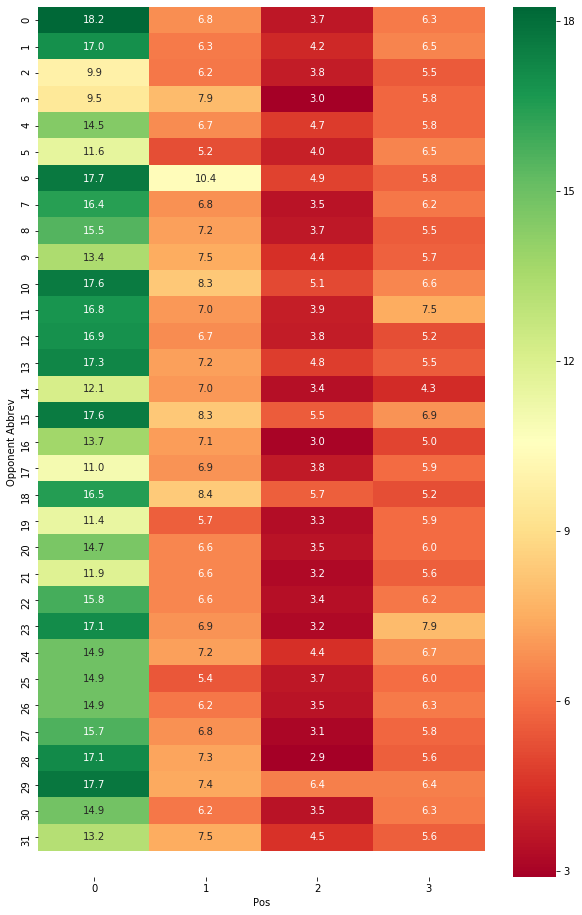

In [251]:
plt.figure(figsize=(10,16))
locations = []

for i in final_data['Indoor/Outdoor']:
    if i == 'outdoors':
        locations.append('Outdoors')
    else:
        locations.append('Indoors')
        
# features we want to look at by position are H/A, indoors/outdoors/, opponent?
reduced_features = final_data[['Pos', 'DK_Total_FP']]
reduced_features['Location'] = locations


df = final_data.pivot_table(index='Opponent Abbrev', columns='Pos', values='DK_Total_FP', aggfunc=np.median)
ax = sns.heatmap(df, cmap="RdYlGn", annot=True, fmt=".1f")
# plt.show
ax.get_ylim()
ax.set_ylim(33, 0)

In [253]:
# now run the model using a neural network 
from sklearn.neural_network import MLPRegressor

# use all the default sklearn parameters (relu activation, adam solver, etc.)
nn = MLPRegressor()

nn.fit(train_features, train_labels)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [254]:
nn_predictions = nn.predict(test_features)

In [255]:
print('Neural Network - MLP Regressor')
print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels, nn_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(test_labels, nn_predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels, nn_predictions)))
print('R2 Score:', metrics.r2_score(test_labels, nn_predictions))

Neural Network - MLP Regressor
Mean Absolute Error: 0.06943081726122108
Mean Squared Error: 0.015659487079531444
Root Mean Squared Error: 0.12513787228306003
R2 Score: 0.9997935812697571


In [256]:
# now let's try with a few Regression models
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

kfold = KFold(n_splits=5, random_state=3)

# for Ridge Regression, use GridSearchCV in order to test for the optinal value of alpha.
rr = Ridge()
ridge_params = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
ridge_reg = GridSearchCV(rr, ridge_params, cv=5)
ridge_reg.fit(train_features, train_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1,
                                   5, 10, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [257]:
rr_predictions = ridge_reg.predict(test_features)

print('Ridge Regression')
print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels, rr_predictions))  
print('Mean Squared Error:', metrics.mean_squared_error(test_labels, rr_predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels, rr_predictions)))
print('Best Parameter:', ridge_reg.best_params_)
print('Best MSE:', ridge_reg.best_score_)

Ridge Regression
Mean Absolute Error: 8.463840684132392e-13
Mean Squared Error: 4.334205870509555e-24
Root Mean Squared Error: 2.081875565568114e-12
Best Parameter: {'alpha': 1e-15}
Best MSE: 1.0


In [258]:
# No idea why this grid search is not converging at the moment.....

# Lasso Regression
lasso = Lasso()
lasso_params = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

lr = GridSearchCV(lasso, lasso_params, cv=5)
lr.fit(train_features, train_labels)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82.97602633706438, tolerance: 55.26437763035202
  positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.16859236915815, tolerance: 54.46052856375473
  positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.53826924216139, tolerance: 56.161920866666655
  positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1,
                                   5, 10, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [259]:
lr_predictions = lr.predict(test_features)

print('Lasso Regression')
print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels, lr_predictions))  
print('Mean Squared Error:', metrics.mean_squared_error(test_labels, lr_predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels, lr_predictions)))
print('Best Parameter:', lr.best_params_)
print('Best MSE:', lr.best_score_)
print('R2 Score:', metrics.r2_score(test_labels, lr_predictions))

Lasso Regression
Mean Absolute Error: 0.0150132887917012
Mean Squared Error: 0.0026075092724605563
Root Mean Squared Error: 0.05106377651976552
Best Parameter: {'alpha': 0.01}
Best MSE: 0.9999285887537179
R2 Score: 0.9999656285834662


In [260]:
en = ElasticNet()
en.fit(train_features, train_labels)

en_predictions = en.predict(test_features)

print('Elastic Net Regression')
print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels, en_predictions))  
print('Mean Squared Error:', metrics.mean_squared_error(test_labels, en_predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels, en_predictions)))
print('R2 Score:', metrics.r2_score(test_labels, en_predictions))

Elastic Net Regression
Mean Absolute Error: 1.3405034013248684
Mean Squared Error: 3.277706956727793
Root Mean Squared Error: 1.8104438562760772
R2 Score: 0.9567942356809263


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.50558343405746, tolerance: 45.248984634169574
  positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.930391507494086, tolerance: 46.57393137234558
  positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.473477570928765, tolerance: 46.17372757642235
  positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_mode

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109.20547024074608, tolerance: 45.248984634169574
  positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.63985455201271, tolerance: 46.17372757642235
  positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100.32686479989329, tolerance: 45.248984634169574
  positive)


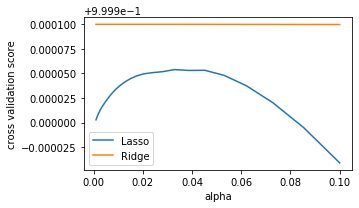

In [261]:
alphas = np.logspace(-3, -1, 30)

plt.figure(figsize=(5, 3))

for Model in [Lasso, Ridge]:
    scores = [cross_val_score(Model(alpha), train_features, train_labels, cv=3).mean()
            for alpha in alphas]
    plt.plot(alphas, scores, label=Model.__name__)

plt.legend(loc='lower left')
plt.xlabel('alpha')
plt.ylabel('cross validation score')
plt.tight_layout()
plt.show()

In [274]:
raw_data

,Player,Pos,Team,Opponent Abbrev,H/A,Team Score,Indoor/Outdoor,Surface,Temperature,Wind,...,Rush TD,Rec Tgt,Rec Rec,Rec Yds,Rec TD,Fmb,Off Pct,DKP,DKSalary,DK_Total_FP
0,Alex Smith,QB,KAN,NWE,A,42.0,outdoors,fieldturf,63.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,100%,34.02,5400.0,34.02
1,Kareem Hunt,RB,KAN,NWE,A,42.0,outdoors,fieldturf,63.0,8.0,...,1.0,5.0,5.0,98.0,2.0,1.0,57%,49.60,5800.0,49.60
2,Charcandrick West,RB,KAN,NWE,A,42.0,outdoors,fieldturf,63.0,8.0,...,1.0,1.0,1.0,4.0,0.0,0.0,34%,9.50,4000.0,9.50
3,Tyreek Hill,WR,KAN,NWE,A,42.0,outdoors,fieldturf,63.0,8.0,...,0.0,8.0,7.0,133.0,1.0,1.0,74%,29.80,5700.0,29.80
4,Travis Kelce,TE,KAN,NWE,A,42.0,outdoors,fieldturf,63.0,8.0,...,0.0,7.0,5.0,40.0,0.0,0.0,99%,9.40,5600.0,9.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15508,Hunter Henry,TE,LAC,KAN,H,17.0,outdoors,grass,67.0,7.0,...,0.0,9.0,6.0,69.0,0.0,0.0,76%,14.90,5700.0,14.90
15509,Virgil Green,TE,LAC,KAN,H,17.0,outdoors,grass,67.0,7.0,...,0.0,1.0,1.0,8.0,0.0,0.0,30%,1.80,2500.0,1.80
15510,Troymaine Pope,RB,LAC,KAN,H,17.0,outdoors,grass,67.0,7.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1%,0.00,3000.0,0.00
15511,Andre Patton,WR,LAC,KAN,H,17.0,outdoors,grass,67.0,7.0,...,0.0,1.0,0.0,0.0,0.0,0.0,74%,0.00,3000.0,0.00


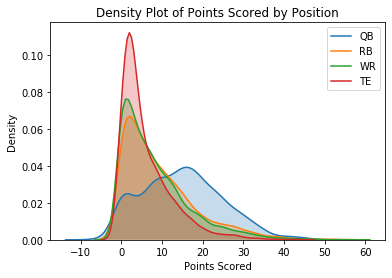

In [275]:
sns.kdeplot(raw_data.loc[raw_data['Pos'] == 'QB', 'DK_Total_FP'], label='QB', shade=True)
sns.kdeplot(raw_data.loc[raw_data['Pos'] == 'RB', 'DK_Total_FP'], label='RB', shade=True)
sns.kdeplot(raw_data.loc[raw_data['Pos'] == 'WR', 'DK_Total_FP'], label='WR', shade=True)
sns.kdeplot(raw_data.loc[raw_data['Pos'] == 'TE', 'DK_Total_FP'], label='TE', shade=True)
plt.xlabel('Points Scored'); plt.ylabel('Density'); plt.title('Density Plot of Points Scored by Position');

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


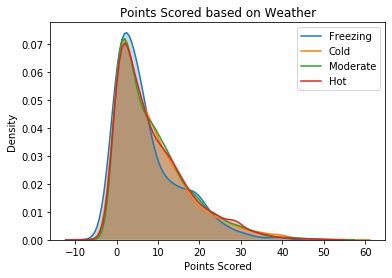

In [276]:
# Thought it might be interesting to look at player points scored distribution based on the weather (temperature)
outdoor_data = raw_data[raw_data['Indoor/Outdoor'] == 'outdoors']

# four buckets of temperature
temps = [0, 30, 50, 75, 100]
labels = ['Freezing', 'Cold', 'Moderate', 'Hot']

outdoor_data['Conditions'] = pd.cut(outdoor_data['Temperature'], temps, labels=labels)

sns.kdeplot(outdoor_data.loc[outdoor_data['Conditions'] == 'Freezing', 'DK_Total_FP'], label='Freezing', shade=True)
sns.kdeplot(outdoor_data.loc[outdoor_data['Conditions'] == 'Cold', 'DK_Total_FP'], label='Cold', shade=True)
sns.kdeplot(outdoor_data.loc[outdoor_data['Conditions'] == 'Moderate', 'DK_Total_FP'], label='Moderate', shade=True)
sns.kdeplot(outdoor_data.loc[outdoor_data['Conditions'] == 'Hot', 'DK_Total_FP'], label='Hot', shade=True)
plt.xlabel('Points Scored'); plt.ylabel('Density'); plt.title('Points Scored based on Weather');



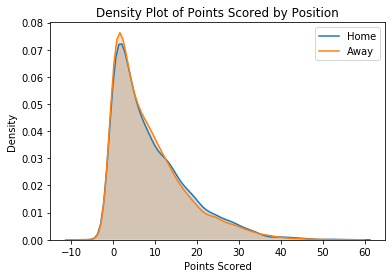

In [277]:
# and player performance for home vs away
sns.kdeplot(raw_data.loc[raw_data['H/A'] == 'H', 'DK_Total_FP'], label='Home', shade=True)
sns.kdeplot(raw_data.loc[raw_data['H/A'] == 'A', 'DK_Total_FP'], label='Away', shade=True)
plt.xlabel('Points Scored'); plt.ylabel('Density'); plt.title('Density Plot of Points Scored by Position');